This notebook explored how a numerical estimate of the mean edit distance between trials converges with the number of pairs of trials sampled for measurement; and confirms our intuition that this converges to the same value as the mean of the distances between every possible pair of trials (which is computationally much cheaper)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spike_train_functions import generate_poisson_unit, randSpkd
from tqdm import tqdm
from dist_metric import spkd_parallel
from itertools import combinations


n_pairs loop: 100%|██████████| 4/4 [00:42<00:00, 10.67s/it]


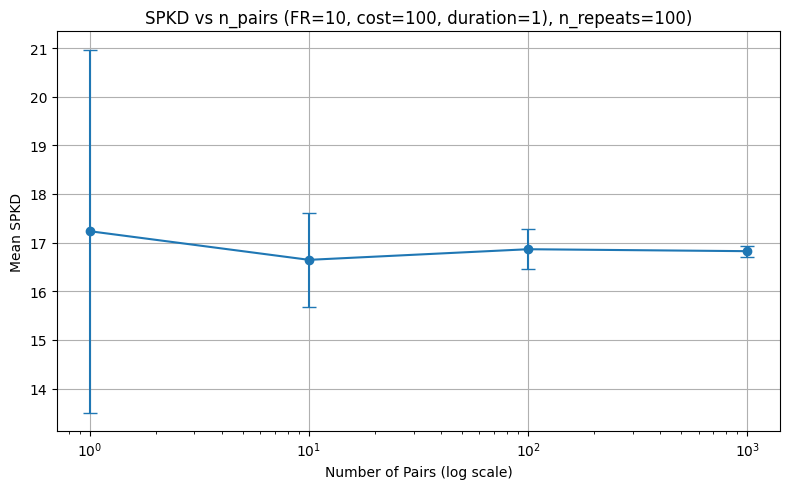

In [ ]:

FR = 10
cost = 100
duration = 1
dt = 1e-4
n_pairs_list = [1, 10, 100, 1000]
repeats = 100

means = []
stds = []

for n_pairs in tqdm(n_pairs_list, desc="n_pairs loop"):
    results = []
    for _ in range(repeats):
        # Simulate spike trains
        spike_trains = generate_poisson_unit(FR, duration=duration, dt=dt, N=n_pairs)
        
        # Compute random SPKD distances
        result = randSpkd(spike_trains, duration=duration, cost=cost)
        results.append(result['mean'])
    
    means.append(np.mean(results))
    stds.append(np.std(results))

# Plotting
plt.figure(figsize=(8, 5))
plt.errorbar(n_pairs_list, means, yerr=stds, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Number of Pairs (log scale)')
plt.ylabel('Mean SPKD')
plt.title(f'SPKD vs n_pairs (FR={FR}, cost={cost}, duration={duration}, repeats={repeats})')
plt.grid(True)
plt.tight_layout()
plt.show()

n_pairs loop: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


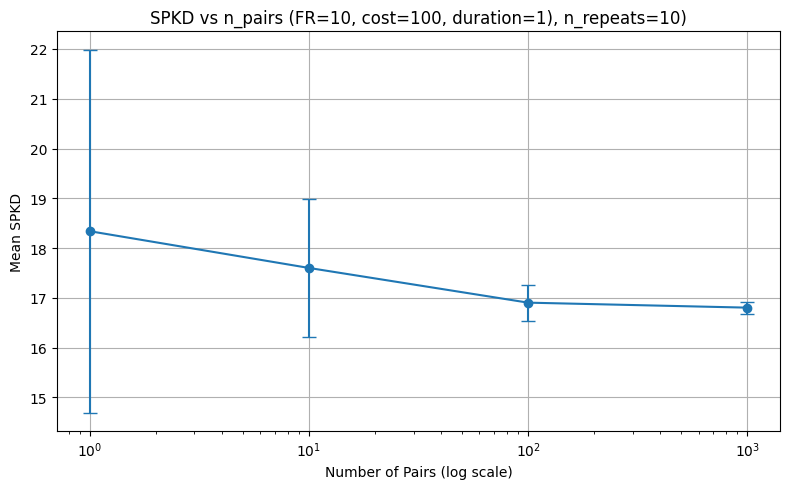

In [ ]:
FR = 10
cost = 100
duration = 1
dt = 1e-4
n_pairs_list = [1, 10, 100, 1000]
repeats = 10

means = []
stds = []

for n_pairs in tqdm(n_pairs_list, desc="n_pairs loop"):
    results = []
    for _ in range(repeats):
        spike_trains = generate_poisson_unit(FR, duration=duration, dt=dt, N=n_pairs)
        result = randSpkd(spike_trains, duration=duration, cost=cost)
        results.append(result['mean'])
    means.append(np.mean(results))
    stds.append(np.std(results))

# Plotting
plt.figure(figsize=(8, 5))
plt.errorbar(n_pairs_list, means, yerr=stds, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Number of Pairs (log scale)')
plt.ylabel('Mean SPKD')
plt.title(f'SPKD vs n_pairs (FR={FR}, cost={cost}, duration={duration}, repeats={repeats})')
plt.grid(True)
plt.tight_layout()
plt.show()

n_pairs loop: 100%|██████████| 9/9 [10:35<00:00, 70.60s/it] 


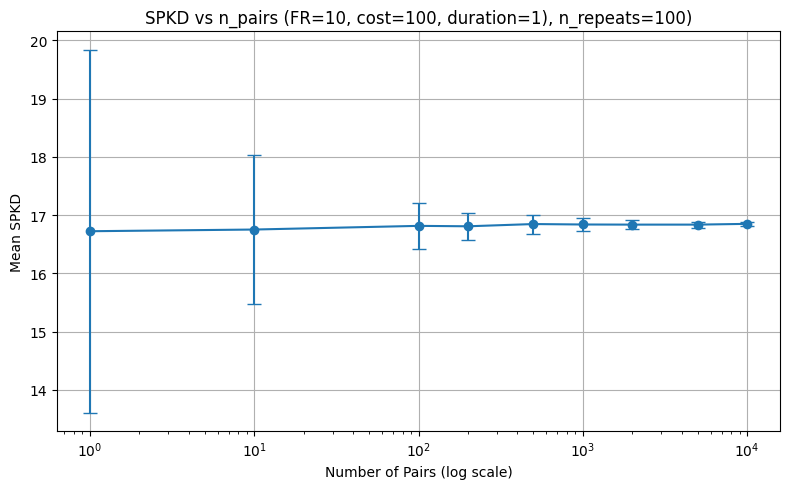

In [ ]:
FR = 10
cost = 100
duration = 1
n_pairs_list = [1, 10, 100, 200, 500, 1000, 2000, 5000, 10000]

repeats = 100

means = []
stds = []

for n_pairs in tqdm(n_pairs_list, desc="n_pairs loop"):
    results = []
    for _ in range(repeats):
        spike_trains = generate_poisson_unit(FR, duration=duration, dt=dt, N=n_pairs)
        result = randSpkd(spike_trains, duration=duration, cost=cost)
        results.append(result['mean'])
    means.append(np.mean(results))
    stds.append(np.std(results))

# Plotting
plt.figure(figsize=(8, 5))
plt.errorbar(n_pairs_list, means, yerr=stds, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Number of Pairs (log scale)')
plt.ylabel('Mean SPKD')
plt.title(f'SPKD vs n_pairs (FR={FR}, cost={cost}, duration={duration}), n_repeats={repeats})')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
means

[16.7235,
 16.7525,
 16.815493,
 16.808180999999998,
 16.8466938,
 16.8390438,
 16.836853599999998,
 16.836893279999998,
 16.84984355]

In [10]:
stds

[3.117337124855122,
 1.274613466898887,
 0.3976760946436183,
 0.22981360520865582,
 0.16375333322274702,
 0.10958172986205343,
 0.08150872936710542,
 0.05271670841281335,
 0.03963313146809731]

In [13]:
spkd_dict = {
    n: {"mean_spkd": m, "std_spkd": s}
    for n, m, s in zip(n_pairs_list, means, stds)
}


In [14]:
spkd_dict

{1: {'mean_spkd': 16.7235, 'std_spkd': 3.117337124855122},
 10: {'mean_spkd': 16.7525, 'std_spkd': 1.274613466898887},
 100: {'mean_spkd': 16.815493, 'std_spkd': 0.3976760946436183},
 200: {'mean_spkd': 16.808180999999998, 'std_spkd': 0.22981360520865582},
 500: {'mean_spkd': 16.8466938, 'std_spkd': 0.16375333322274702},
 1000: {'mean_spkd': 16.8390438, 'std_spkd': 0.10958172986205343},
 2000: {'mean_spkd': 16.836853599999998, 'std_spkd': 0.08150872936710542},
 5000: {'mean_spkd': 16.836893279999998, 'std_spkd': 0.05271670841281335},
 10000: {'mean_spkd': 16.84984355, 'std_spkd': 0.03963313146809731}}

In [ ]:
def bootstrap_by_resampled_pairs(spike_trains, cost, duration=1, n_repeats=100, n_pairs_list=None):
    if n_pairs_list is None:
        n_pairs_list = [10, 20, 50, 100, 200, 500, 1000]

    all_indices = list(combinations(range(len(spike_trains)), 2))  # All 190 unique (i < j) pairs
    results_mean = []
    results_std = []

    for n_pairs in tqdm(n_pairs_list, desc="n_pairs bootstrap"):
        means = []
        for _ in range(n_repeats):
            sampled_idx = np.random.choice(len(all_indices), size=n_pairs, replace=True)
            pairs = [all_indices[i] for i in sampled_idx]
            tli = [spike_trains[i] for i, j in pairs]
            tlj = [spike_trains[j] for i, j in pairs]
            dists = spkd_parallel(tli, tlj, duration=duration, cost=cost, n_jobs=-1)
            means.append(np.mean(dists))
        results_mean.append(np.mean(means))
        results_std.append(np.std(means))

    return n_pairs_list, results_mean, results_std


means_all_unique = []


# === Parameters ===
FR = 10
cost = 100
duration = 1
dt = 1e-4
N = 20
n_repeats = 100
n_pairs_list = [10, 20, 50, 100, 200, 500, 1000]

# Generate 20 fixed spike trains
spike_trains = generate_poisson_unit(FR, duration, dt, N)

# Run bootstrap over different numbers of resampled pairs
x_vals, mean_vals, std_vals = bootstrap_by_resampled_pairs(spike_trains, cost, duration, n_repeats, n_pairs_list)


# Use same spike trains that were generated once before bootstrap
index_pairs = list(combinations(range(len(spike_trains)), 2))
tli = [spike_trains[i] for i, j in index_pairs]
tlj = [spike_trains[j] for i, j in index_pairs]
dists = spkd_parallel(tli, tlj, duration=duration, cost=cost, n_jobs=-1)
mean_all_unique = np.mean(dists)


n_pairs bootstrap: 100%|██████████| 7/7 [00:23<00:00,  3.36s/it]


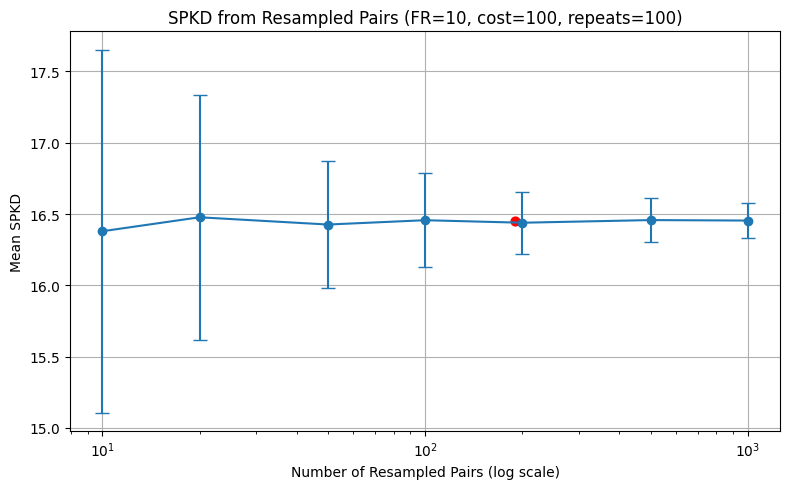

In [41]:
# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(x_vals, mean_vals, yerr=std_vals, fmt='o-', capsize=5)

plt.scatter(
    [190], [mean_all_unique],
    color='red', marker='o', s=40,
    label='All 190 Unique Pairs (fixed spike trains)'
)



plt.xscale('log')
plt.xlabel('Number of Resampled Pairs (log scale)')
plt.ylabel('Mean SPKD')
plt.title(f'SPKD from Resampled Pairs (FR={FR}, cost={cost}, repeats={n_repeats})')
plt.grid(True)
plt.tight_layout()
plt.show()
